**Deep Learning AA 2022/2023**
** **
Teachers:\
Fabrizio Silvestri (fsilvestri@diag.uniroma1.it)\
Antonio Purificato (antonio.purificato@uniroma1.it)\
Farooq Wani (wani@diag.uniroma1.it)\
Maria Sofia Bucarelli (bucarelli.diag@uniroma1.it) \

In [ ]:
import torch

In [ ]:
%matplotlib inline
from matplotlib import pyplot
import numpy as np

http://blog.ezyang.com/2019/05/pytorch-internals/


Tensors

At the heart of PyTorch is the Tensor data type.

A torch.Tensor is a multi-dimensional matrix containing elements of a single data type.

https://pytorch.org/docs/stable/tensors.html

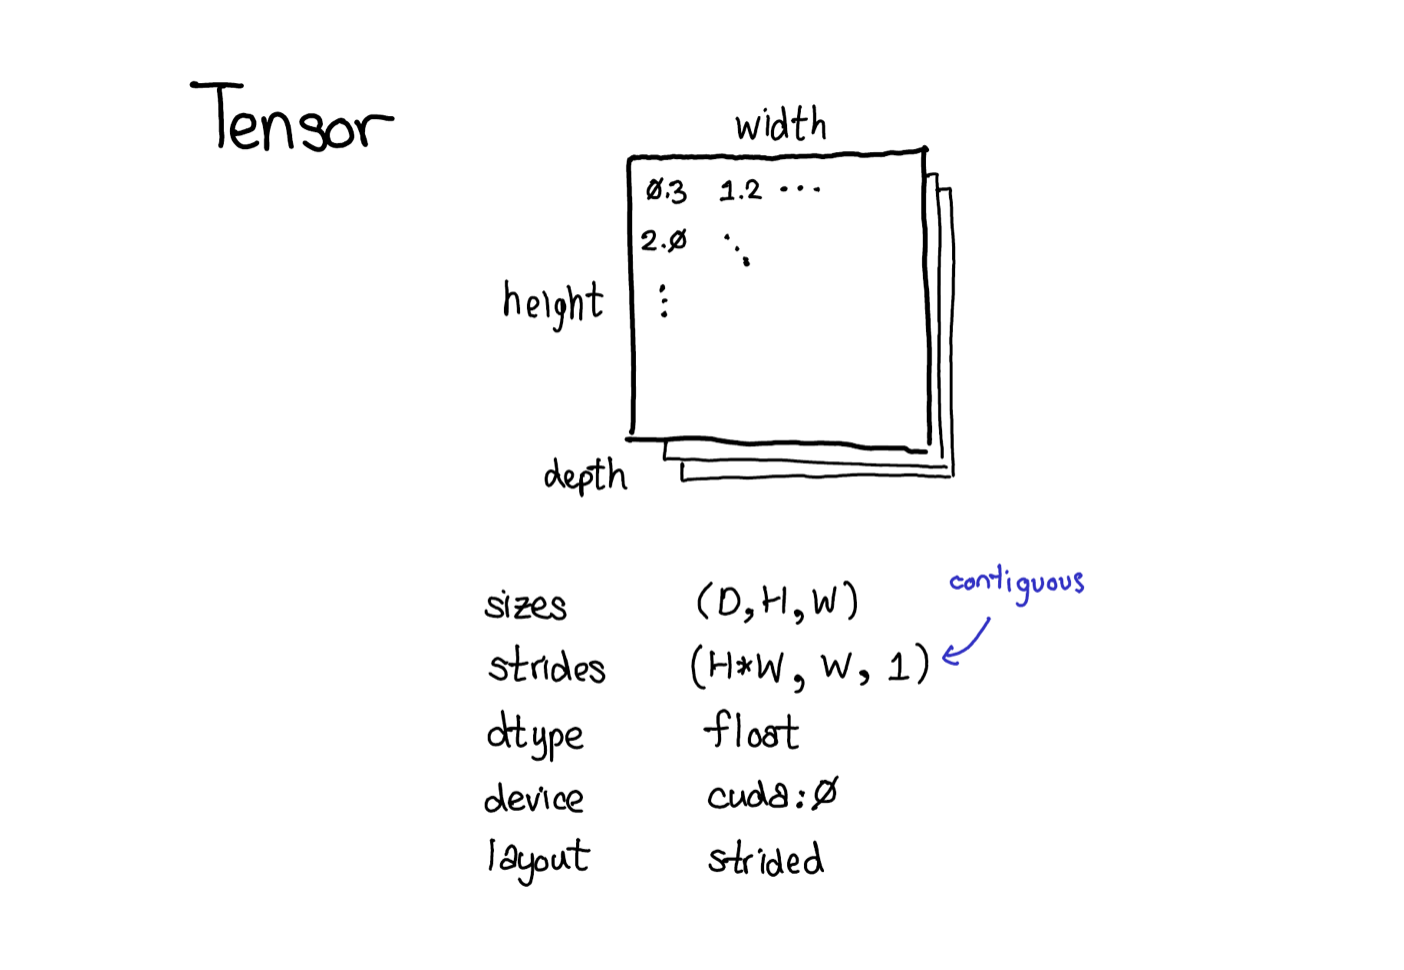

## Our first tensor

In [ ]:
#from a Python list
t = torch.tensor([[1,2],[3,4]])
#from a numpy array
t1 = torch.tensor(np.arange(10))

t,t1

(tensor([[1, 2],
         [3, 4]]),
 tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

## Tensors are arrays
Tensors have a shape (the size of each dimension):


Indexing - also with assignments - works as expected. Use .item() to get numbers from tensors.

In [ ]:
t.dim(), t.shape

(2, torch.Size([2, 2]))

Slicing works just like for lists/in NumPy

In [ ]:
t[0,0]

tensor(1)

In [ ]:
t[0,0].item()

1

`None` adds a new (size 1) dimension.

In [ ]:
t[:,:,None].size()

torch.Size([2, 2, 1])

"Advanced indexing" with masks also works

In [ ]:
t

tensor([[1, 2],
        [3, 4]])

In [ ]:
t[t>2]

tensor([3, 4])

## Tensor element types

Tensors always hold elements (numbers) of a given scalar type, the "data type" or dtype.
There are many:


- `torch.float32` aka `torch.float`
- `torch.float64` aka `torch.double`
- `torch.float16`/`half`, `bf16`
- `int8`, `uint8`, `int16`, `int32`/`int`, `int64`/`long`
- `torch.bool`
- `torch.complex32`, `complex64`, `complex128` (with half/float/double real and imaginary part)
- `torch.quint8` `quint4x2` etc. for quantized tensors

For PyTorch (with its GPU focus), `float32` is perhaps the most common dtype.

For indexing, `int64` is often used, but `int32` can be much faster if it works, e.g. on GPUs.

Query dtype

In [ ]:
t.dtype

torch.int64

Specify dtype in factory functions

In [ ]:
t = torch.tensor( np.arange(3), dtype = torch.float)
t

tensor([0., 1., 2.])

Convert (i.e. copy to a new tensor of the desired dtype if necessary)

In [ ]:
t.to(dtype = torch.int)

tensor([0, 1, 2], dtype=torch.int32)

Old way (less neat in some ways):

In [ ]:
t.int()

tensor([0, 1, 2], dtype=torch.int32)

## Putting Tensors on the GPU

Tensors have a device.
We can move between devices and just as we convert between dtypes.

In [ ]:
torch.cuda.is_available()

True

In [ ]:
t.device

device(type='cpu')

Change device

In [ ]:
t.to(device = 'cuda', dtype= torch.int)

tensor([0, 1, 2], device='cuda:0', dtype=torch.int32)

You can also create device objects. Note that `"cuda"` is an alias for the "default" gpu, `"cuda:X"` for a given one.

In [ ]:
torch.device('cuda')
device1 = torch.device('cuda:0')

## Tensors - a scenic view of memory blobs

Internally, Tensors are (most often) stored as a blob of memory.

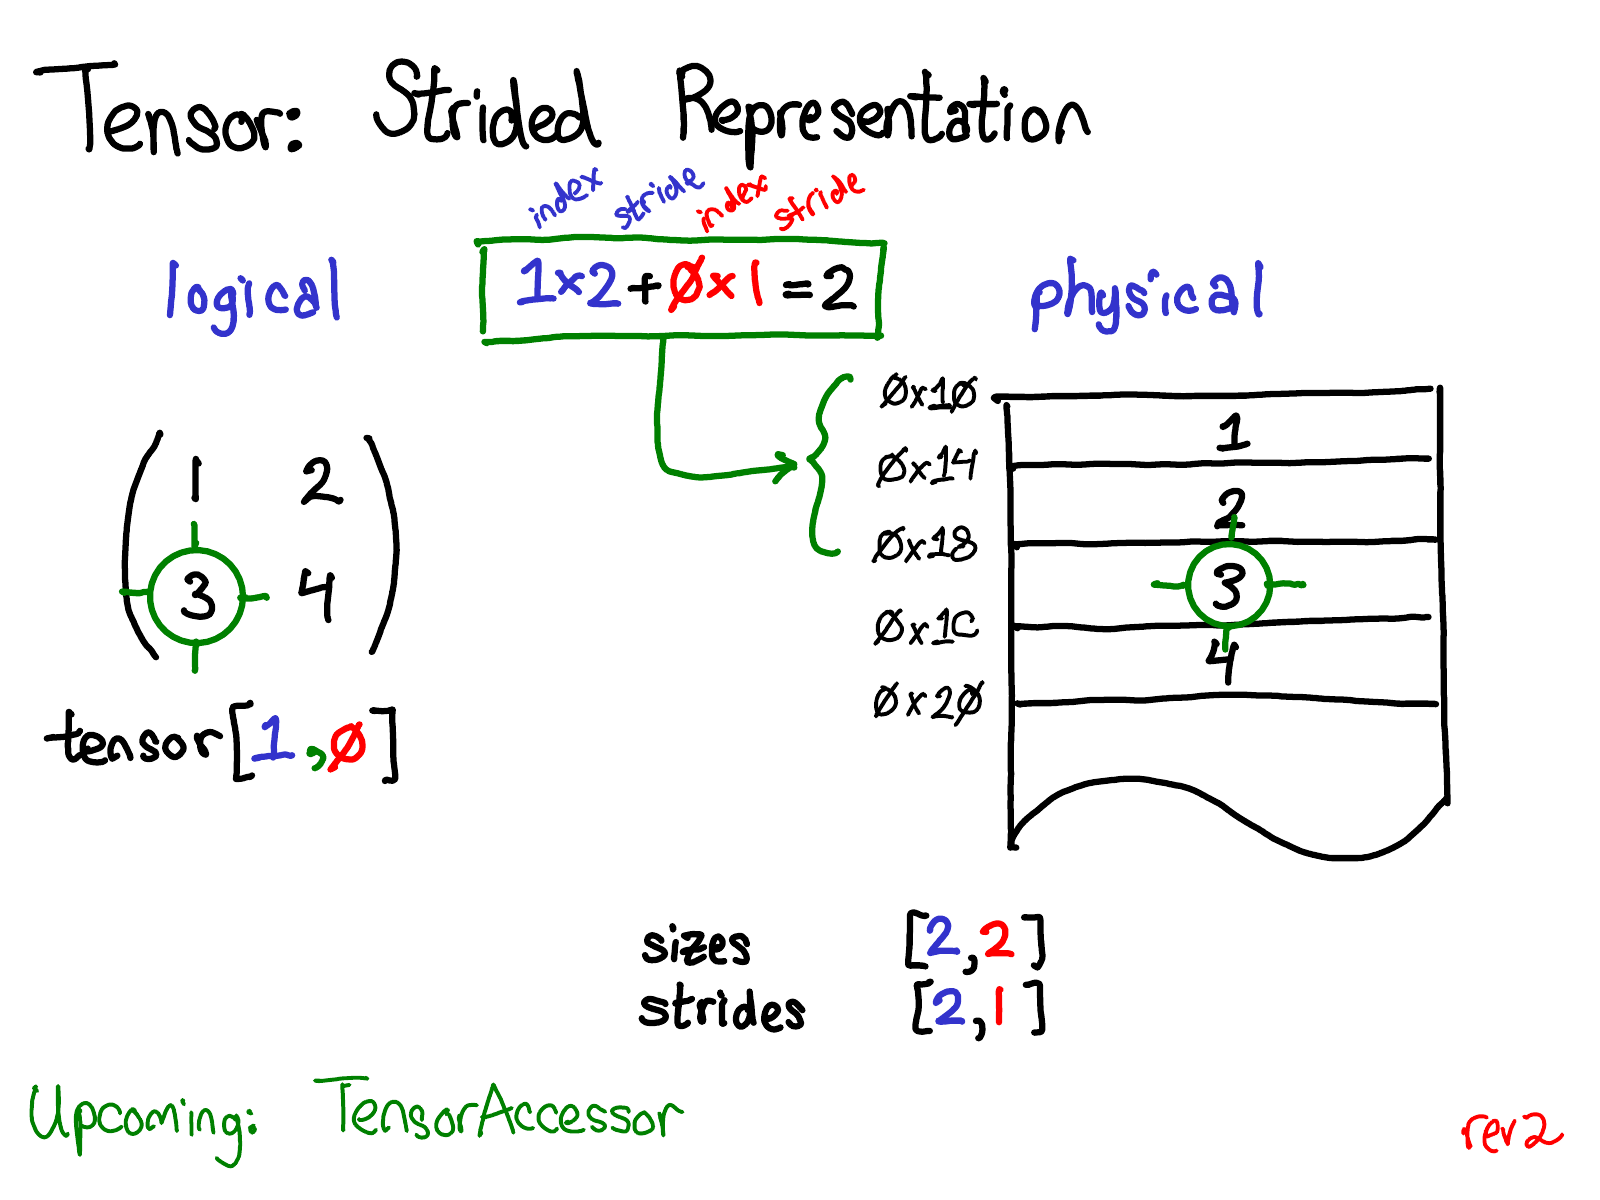

Stride is the jump necessary to go from one element to the next one in the specified dimension dim.

So in the above example, the index `[1, 0]` transforms into the memory location `1 * t.stride(0) + 0 * t.stride(1)` = `1 * 2 + 0 * 1`, i.e. memory location 2 (with 0-based counting).

In [ ]:
t = torch.tensor(np.arange(24).reshape([2,3,4]))
t

tensor([[[ 0,  1,  2,  3],
         [ 4,  5,  6,  7],
         [ 8,  9, 10, 11]],

        [[12, 13, 14, 15],
         [16, 17, 18, 19],
         [20, 21, 22, 23]]])

In [ ]:
t.storage()

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
 18
 19
 20
 21
 22
 23
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 24]

In [ ]:
t.stride()

(12, 4, 1)

In [ ]:
12*1 + 4*1 + 1*1

17

In [ ]:
t[1,1,1]

tensor(17)

Indexing and slicing (and taking diagonals, too) do *not* copy, but create views:

In [ ]:
t1 = t[0,:,:]
t1

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]])

In [ ]:
t1.storage()

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
 18
 19
 20
 21
 22
 23
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 24]

In [ ]:
t.data_ptr(), t1.data_ptr()

(100969524909632, 100969524909632)

![](http://blog.ezyang.com/img/pytorch-internals/slide-07.png)


## Tensor metadata

The size, stride, and offset and `data_ptr` (in addition to dtype, device) are key Tensor _metadata_. They inform PyTorch of how it should resolve a tensor location to a memory location.

The metadata is always stored on the CPU, but typically provided to CUDA kernels as we go along.


A tensor where the strides are descending and there are no "gaps" in the storage is called `contiguous`. You can force to get one (by copying as needed) through `t = t.contiguous()`.

## Common View-Creating Operations

- `.t()` and `.transpose(...)`, `.permute(...)`: change the order of axes in the stride/size metadata. So when you transpose a tensor PyTorch doesn't generate a new tensor with a new layout, it just modifies meta information in the Tensor object so that the offset and stride describe the desired new shape
- `.view(...)`: change the stride/size (but might not work, if the new layout cannot be expressed in stride/size)
- (Single) Indexing: drops one dimension, changes offset for indices other than `0`.

Special case: `reshape` creates a view (like `view`) if possible and copies the tensor if not.


when you call transpose(), PyTorch

# If you need a copy

You can use `t.clone()` to forcefully create a copy (or `.to(device=..., dtype=..., copy=True)` if you need a conversion that is guaranteed to copy if the tensor is already in the right form.

In [ ]:
t1 = t.to(copy= True)
t1.data_ptr(), t.data_ptr()

(100968493933184, 100969524909632)

## Generalized tensors are tensors, too.

- These were strided tensors
- There are other Tensor types: Sparse, on TPU,...
- Quantized is a bit special, but similar in spirit.



In [ ]:
t.layout

torch.strided

A [torch.layout](https://pytorch.org/docs/stable/tensor_attributes.html#torch-layout) is an object that represents the memory layout of a torch.Currently, PyTorch support torch.strided (dense Tensors) and have beta support for [torch.sparse_coo](https://pytorch.org/docs/stable/generated/torch.sparse_coo_tensor.html#torch-sparse-coo-tensor) (sparse COO Tensors). \\

Sparse arrays have a property of having a vast portion of elements being equal to zero which means that a lot of memory as well as processor resources can be spared if only the non-zero elements are stored or/and processed. Various sparse [storage formats](https://en.wikipedia.org/wiki/Sparse_matrix) (such as COO, CSR/CSC, LIL, etc.) have been developed that are optimized for a particular structure of non-zero elements in sparse arrays as well as for specific operations on the arrays.



In [ ]:
 i = [[0,1,1],[2,3,1]]
 v  =  [1,2,3]
 s = torch.sparse_coo_tensor(indices = i, values = v)
 s

tensor(indices=tensor([[0, 1, 1],
                       [2, 3, 1]]),
       values=tensor([1, 2, 3]),
       size=(2, 4), nnz=3, layout=torch.sparse_coo)

`to_dense()` to obtain a dense version of the sparese tensor

In [ ]:
s.to_dense()

tensor([[0, 0, 1, 0],
        [0, 3, 0, 2]])

In [ ]:
s = torch.sparse_coo_tensor(torch.arange(10)[None], torch.randn(10))
s, s.layout

(tensor(indices=tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]),
        values=tensor([ 0.9662, -1.7792, -0.9999,  0.2872, -2.3608, -0.2365,
                       -0.6460, -0.9365, -1.1985,  1.6518]),
        size=(10,), nnz=10, layout=torch.sparse_coo), torch.sparse_coo)

In [ ]:
s.to_dense()

tensor([ 0.9662, -1.7792, -0.9999,  0.2872, -2.3608, -0.2365, -0.6460, -0.9365,
        -1.1985,  1.6518])

In [ ]:
indices = [[0,1,2,9],[0,1,0,9]]
s = torch.sparse_coo_tensor(indices, torch.randn(4))

In [ ]:
s.to_dense()

tensor([[-0.4758,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000, -0.0851,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [-0.1077,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  

### Where to get Tensors?

PyTorch has ~90 factory functions:

- torch.tensor, torch.sparse_coo_tensor
- torch.zeros, ones, randn, ...
- torch.zeros_like, ones_like, randn_like, ...

Conversion to and from Numpy works without copying (there also is `torch.utils.dlpack` for a similar effect with GPU tensors)

In [ ]:
b = np.random.rand(10).reshape([2,5])
b

array([[0.21482651, 0.74424614, 0.44959713, 0.5364045 , 0.22503995],
       [0.39443809, 0.89899639, 0.64889361, 0.16453321, 0.25693216]])

In [ ]:
t2 = torch.from_numpy(b)
t = torch.tensor(b)

t2.data_ptr() == t.data_ptr()

False

In [ ]:
t.numpy()

array([1, 2, 4])

In [ ]:
a = t2.numpy()
t2 = torch.from_numpy(a)
t2.data_ptr() == t.data_ptr()

True

Careful: Numpy uses a dtype of float64 by default, PyTorch float32 (as you typically want that for GPUs)


There also are `torch.utils.dlpack.to_dlpack` / `from_dlpack` for interchange with GPU tensors.

### Saving and loading tensors

Saving and loading tensors and dicts, lists of them (and other types) can be done though `torch.save` and `torch.load`. Optionally, you can specify where the tensors should be loaded to (the default is to put GPU tensors back on the GPU).

In [ ]:
torch.save(t, 'my-tensor.pt')
torch.load('my-tensor.pt', map_location="cpu")

tensor([[0.2148, 0.7442, 0.4496, 0.5364, 0.2250],
        [0.3944, 0.8990, 0.6489, 0.1645, 0.2569]], dtype=torch.float64)

**Style advice**: Do use `.pt` as an extension, not `.pth` or anything else (`pth` collides with Python "path" files).

# PyTorch is ... operations on tensors

PyTorch mostly follows numpy in naming. Most things are available as methods (`t.tanh()`) and functions (`torch.tanh(t)`). More neural-network specific things are in `torch.nn.functional`.

We're not going to list them, but generally we follow NumPy naming, the [documentation](https://pytorch.org/docs/) has all the details.

# Inplace operations

Inplace operations modify their inputs instead of creating new tensors as outputs are signaled by a trailing underscore `_`.

Technically, you modify the memory where the tensor lives, i.e. the storage we saw above. This means you change all tensors that use this storage (unless they use a part you don't modify).


The `torch.nn.functional` namespace (sometimes mapped to `F`) contains functions that are more neural-network related.


In [ ]:
import torch.nn.functional as F

w = torch.randn(10, 5)
i = torch.randn(2, 5)
F.linear(i, w)

tensor([[ 0.8521, -2.9486, -4.0286,  4.0670,  6.1062, -3.3350,  0.1268,  3.8174,
         -2.9990,  2.8851],
        [ 1.3301,  1.2692,  1.5741, -6.9083, -7.7148,  1.1326,  0.9733, -2.6264,
         -3.3077, -1.3436]])

## Some important core PyTorch API

At a very high level, these are some important "core" classes:

- Creation ops, like `tensor`, `ones`, `zeros` and `from_numpy`.
  - these include many random sampling functions (`randn`, `multinomial`), but there are also (somewhat peculier) ones like `Tensor.uniform_`.
- Indexing, slicing, joining, mutating op
- Math ops
  - Pointwise ops like `tanh` and `sqrt`, `add` (aka `+` operator), comparisons
  - Reduction ops like `sum`, `prod`, `mean` , `std` , `norm`, `max`
  - Matrix multiplication and other linear algebra
  - more specialized math operations, like fft, etc.
  - Serialization like `load` and `save`
- Neural-Network-Functions in `torch.nn.functional`
- Admin—Functions, e.g. `set_num_threads`, `torch.cuda.is_available()`

#Broadcasting Semantics

Many PyTorch operations support NumPy’s broadcasting semantics

Two tensors must have the same shape in order to perform element-wise operations.
So why can we do this?

In [ ]:
T = torch.ones([2,3])
T, T+2

(tensor([[1., 1., 1.],
         [1., 1., 1.]]),
 tensor([[3., 3., 3.],
         [3., 3., 3.]]))

Brodcasting!

The term broadcasting describes how NumPy treats arrays with different shapes during arithmetic operations. Subject to certain constraints, the smaller array is “broadcast” across the larger array so that they have compatible shapes.
Broadcasting provides a means of vectorizing operations on arrays so that looping occurs in C rather than Python. This is done without creating unnecessary copies of the data and usually leads to efficient implementations of the algorithms.



A one dimensional array added to a two dimensional array results in broadcasting if number of 1-d array elements matches the number of 2-d array columns.
So we can do the following:

In [ ]:
a = torch.arange(12).reshape([3,4])
b = torch.ones([4])
a.shape, b.shape, (a+b).shape, a+b

(torch.Size([3, 4]),
 torch.Size([4]),
 torch.Size([3, 4]),
 tensor([[ 1.,  2.,  3.,  4.],
         [ 5.,  6.,  7.,  8.],
         [ 9., 10., 11., 12.]]))

But we can't to the following:

In [ ]:
a = torch.arange(12).reshape([4,3])
b = torch.arange(4)
print(a.shape, b.shape)
a + b

torch.Size([4, 3]) torch.Size([4])


RuntimeError: ignored

https://numpy.org/doc/stable/user/basics.broadcasting.html#broadcasting-figure-2

In [ ]:
(a[:,None]).shape


torch.Size([4, 1, 3])

In [ ]:
a = torch.arange(start=1, end=5,step=1)
b = torch.arange(start=1, end=4,step=1)
print(a, b)
print(a[:,None]*b)


tensor([1, 2, 3, 4]) tensor([1, 2, 3])
tensor([[ 1,  2,  3],
        [ 2,  4,  6],
        [ 3,  6,  9],
        [ 4,  8, 12]])


In-place operations do not allow the in-place tensor to change shape as a result of the broadcast. That's why the following code produces an error

In [ ]:
x=torch.empty(2,3,1)
y=torch.empty(3,1)
(x.add_(y)).size()

torch.Size([2, 3, 1])

In [ ]:
x=torch.ones(1,3)
y=torch.ones(3,1)
x,y, x+y, (x+y).shape


(tensor([[1., 1., 1.]]),
 tensor([[1.],
         [1.],
         [1.]]),
 tensor([[2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.]]),
 torch.Size([3, 3]))

In [ ]:
x.add_(y)

RuntimeError: ignored

Reshape $\neq$ Transpose

In [ ]:
t

tensor([[[ 0,  1,  2,  3],
         [ 4,  5,  6,  7],
         [ 8,  9, 10, 11]],

        [[12, 13, 14, 15],
         [16, 17, 18, 19],
         [20, 21, 22, 23]]])

In [ ]:
t.shape

torch.Size([2, 3, 4])

In [ ]:
t.T

<ipython-input-36-42febba05243>:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  t.T


tensor([[[ 0, 12],
         [ 4, 16],
         [ 8, 20]],

        [[ 1, 13],
         [ 5, 17],
         [ 9, 21]],

        [[ 2, 14],
         [ 6, 18],
         [10, 22]],

        [[ 3, 15],
         [ 7, 19],
         [11, 23]]])

In [ ]:
t.T.shape, t.T.stride(), t.stride()

(torch.Size([4, 3, 2]), (1, 4, 12), (12, 4, 1))

In [ ]:
t.reshape([4,3,2]), t.T

(tensor([[[ 0,  1],
          [ 2,  3],
          [ 4,  5]],
 
         [[ 6,  7],
          [ 8,  9],
          [10, 11]],
 
         [[12, 13],
          [14, 15],
          [16, 17]],
 
         [[18, 19],
          [20, 21],
          [22, 23]]]),
 tensor([[[ 0, 12],
          [ 4, 16],
          [ 8, 20]],
 
         [[ 1, 13],
          [ 5, 17],
          [ 9, 21]],
 
         [[ 2, 14],
          [ 6, 18],
          [10, 22]],
 
         [[ 3, 15],
          [ 7, 19],
          [11, 23]]]))

## Exercises

###**Exercise 1**
Write a 3x3x3 tensor $z$ that has all ones on the diagonal, i.e.
$$ z_{ijk} = \begin{cases} &1 \text{ if } i=j=k \\
& 0 \text{ otherwise}
 \end{cases}$$


In [ ]:
# your solution...


###**Exercise 2**

Given the tensors $x=$ torch.linspace(-1, 1, 10) and $y=$ torch.linspace(-1, 1, 20) as below, write a 10 x 20 tensor $ z$ so that $z_{ij} = (3*x_i^2 + sin(y_j))$   

In [ ]:
x = torch.linspace(-1, 1, 10)
y = torch.linspace(-1, 1, 20)
# your solution ...

x.shape


torch.Size([10])

###**Exercise 3**

Given the 3x2x4 $x$ defined as below  find the mean along the 3rd dimension.
You should return as output a 3x2 tensor.

In [ ]:
x = torch.arange(24).reshape([3,2,4]).to(dtype=torch.float64)

# your solution

###**Exercise 4**

Given the 2x2x2 $x$ defined as below  return as output  1d tensor of two elements $z$  so that $z_i = \max_{j}( \sum_{k=1}^2 x_{ijk}) $

In [ ]:
x = torch.arange(8).reshape([2,2,2])

# your solution

###**Exercise 5**

Given a 3x3 tensor $x$ as below, return the tensor $y$ so that each element of $y$ is so that
$$y_{ij} = \begin{cases}& x_{ij}  & \text{ with probability } \frac{3}{4} \\
-& x_{ij}  & \text{ with probability } \frac{1}{4} \\
\end{cases} $$

## Automatic differentiation

When training neural networks, the most frequently used algorithm is back propagation. In this algorithm, parameters (model weights) are adjusted according to the gradient of the loss function with respect to the given parameter.

To compute those gradients, PyTorch has a built-in differentiation engine called torch.autograd. It supports automatic computation of gradient for any computational graph and allows us to dynamically define computational graphs that can be evaluated efficently on GPUs.

[Autograd](https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html)

In [ ]:
param = torch.tensor([1.0], requires_grad=True)
param

tensor([1.], requires_grad=True)

In [ ]:
data = torch.tensor([1.0])

In [ ]:
(data + param)

tensor([2.], grad_fn=<AddBackward0>)

In [ ]:
import torch

# Create a tensor with a value
x = torch.tensor(2.0, requires_grad=True)

# We create a PyTorch tensor 'x' with the value 2.0 and set 'requires_grad=True' to enable automatic differentiation.

# Define a simple function
def f(x):
    return x**2 + 2*x + 1

# We define a simple function 'f(x)' that takes 'x' as input and computes 'x^2 + 2x + 1'.

# Compute the function value
y = f(x)




We use 'backward()' to compute the gradients of 'y' with respect to 'x'. This is where automatic differentiation happens.

In [ ]:
y.backward()

Access the derivative (gradient) of the function at x

In [ ]:
gradient = x.grad

#We access the gradient of 'y' with respect to 'x', which represents the derivative of 'f(x)' with respect to 'x'.

print("Function value (f(x)): ", y.item())
print("Gradient (df/dx) at x=2: ", gradient.item())

Function value (f(x)):  9.0
Gradient (df/dx) at x=2:  6.0


###Disabling Gradient Tracking

By default, all tensors with requires_grad=True are tracking their computational history and support gradient computation.
We can stop tracking computations by surrounding our computation code with `torch.no_grad()` block:

In [ ]:
x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)


z = torch.matmul(x, w)+b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w)+b
print(z.requires_grad)

True
False


Another way to achieve the same result is to use the `detach()` method on the tensor:

In [ ]:
z = torch.matmul(x, w)+b
z_det = z.detach()
print(z_det.requires_grad)

False


# Non-leaf nodes gradient:
We create two tensors x and y, both with `requires_grad=True `
to enable gradient computation.
We compute a non-leaf node z by multiplying x and y.

In [ ]:
import torch

# Create two tensors
x = torch.tensor(2.0, requires_grad=True)
y = torch.tensor(3.0, requires_grad=True)

# Compute a non-leaf node using these tensors
z = (x * y)**2

# Try to compute the gradient of 'z'
try:
    z.backward()
except RuntimeError as e:
    print(f"Error: {e}")

# Access the gradients
gradient_x = x.grad
gradient_y = y.grad

# Print the gradients (will be None for non-leaf nodes)
print("Gradient of x: ", gradient_x)
print("Gradient of y: ", gradient_y)




Gradient of x:  tensor(36.)
Gradient of y:  tensor(24.)


In [ ]:
print(z.grad)

None


<ipython-input-61-c4ef32dfae4c>:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:486.)
  print(z.grad)


Note that in a typical neural network, all parameters are leaf nodes. They are not computed from any other Variables in the network.